## Baseline Model
**<u>Project Contribtors:</u>** 
Everett Holmes - All Data Modeling following cell 5, Model Improvements, README.md Report |
Alec Groseclose - Initial data loading, First 5 cells describing dataset |
Logan Lay - Initial Model Research

In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing  import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report, confusion_matrix, precision_recall_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier

In [152]:
# loading dataset assuming you have downloaded the dataset from kaggle
# using the link below and have it in a /data folder
df = pd.read_csv("../data/LI-Small_Trans.csv")


## Dataset Highlights and Attributes

<u>Link to Dataset:</u> https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml?select=LI-Small_Trans.csv

<u>Dataset Description<u>

In [153]:
df.describe

<bound method NDFrame.describe of                 Timestamp  From Bank    Account  To Bank  Account.1  \
0        2022/09/01 00:08         11  8000ECA90       11  8000ECA90   
1        2022/09/01 00:21       3402  80021DAD0     3402  80021DAD0   
2        2022/09/01 00:00         11  8000ECA90     1120  8006AA910   
3        2022/09/01 00:16       3814  8006AD080     3814  8006AD080   
4        2022/09/01 00:00         20  8006AD530       20  8006AD530   
...                   ...        ...        ...      ...        ...   
6924044  2022/09/10 23:39      71696  81B2518F1    71528  81C0482E1   
6924045  2022/09/10 23:48     271241  81B567481   173457  81C0DA751   
6924046  2022/09/10 23:50     271241  81B567481   173457  81C0DA751   
6924047  2022/09/10 23:57     170558  81A2206B1   275798  81C1D5CA1   
6924048  2022/09/10 23:31     170558  81A2206B1   275798  81C1D5CA1   

         Amount Received Receiving Currency   Amount Paid Payment Currency  \
0           3.195403e+06          U

<u>Shape of the dataset</u>

In [154]:
print("Number of Instances: " + str(df.shape[0]))
print("Number of Attributes: " + str(df.shape[1]))

df.shape

Number of Instances: 6924049
Number of Attributes: 11


(6924049, 11)

<u>Dataset Information</u>

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6924049 entries, 0 to 6924048
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Timestamp           object 
 1   From Bank           int64  
 2   Account             object 
 3   To Bank             int64  
 4   Account.1           object 
 5   Amount Received     float64
 6   Receiving Currency  object 
 7   Amount Paid         float64
 8   Payment Currency    object 
 9   Payment Format      object 
 10  Is Laundering       int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 581.1+ MB


<u>Attributes and types:</u>

In [156]:
df.dtypes.to_frame("Data Type")

,Data Type
Timestamp,object
From Bank,int64
Account,object
To Bank,int64
Account.1,object
Amount Received,float64
Receiving Currency,object
Amount Paid,float64
Payment Currency,object
Payment Format,object


<u>Random Sample of the data:</u>

In [157]:
df.sample(5)

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
4720616,2022/09/07 10:23,3597,803616010,115481,805E8BA10,365.22,US Dollar,365.22,US Dollar,Cheque,0
2017814,2022/09/02 11:13,3100,805534530,3100,805534530,3618.57,Euro,4240.18,US Dollar,ACH,0
51292,2022/09/01 00:19,18081,807A11330,18081,807A11330,11470.11,US Dollar,11470.11,US Dollar,Reinvestment,0
6691891,2022/09/10 02:59,27425,801CF93A0,210858,805201B30,1528.17,Yuan,1528.17,Yuan,Cheque,0
371103,2022/09/01 00:03,44474,8105089E0,44474,8105089E0,799.11,Australian Dollar,799.11,Australian Dollar,Reinvestment,0


<u>Number of missing values: </u>

In [158]:
# Create a new DataFrame with missing values summary
missing_values = pd.DataFrame({
    "Column Name": df.columns,
    "Missing Count": df.isnull().sum(),
    "Missing Percentage": (df.isnull().sum() / len(df)) * 100
})

missing_values.head(10)

,Column Name,Missing Count,Missing Percentage
Timestamp,Timestamp,0,0.0
From Bank,From Bank,0,0.0
Account,Account,0,0.0
To Bank,To Bank,0,0.0
Account.1,Account.1,0,0.0
Amount Received,Amount Received,0,0.0
Receiving Currency,Receiving Currency,0,0.0
Amount Paid,Amount Paid,0,0.0
Payment Currency,Payment Currency,0,0.0
Payment Format,Payment Format,0,0.0


<u>Droppng Missing Values if any</u>

In [159]:
# drop rows with missing values
df = df.dropna()

<u>Encoding categorical features in copied dataframe for possible use later for logistic regression</u>

In [160]:
# encode categorical features
categorical_cols = ['Receiving Currency', 'Payment Currency', 'Payment Format']
label_encoders = {}

df_encoded = df.copy()

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

<u>Splitting Features and Target</u>

Splitting into our Training and Testing Sets

In [161]:
# seperating features and target variable
X = df_encoded.drop(columns=['Account', 'Account.1', 'Timestamp', 'Is Laundering'])
y = df_encoded['Is Laundering']


## EDA Graphs

<u>Visualized class imbalance</u>

Extreme class imbalance represented as proportions with bar plot, class 0 has +99.95%.

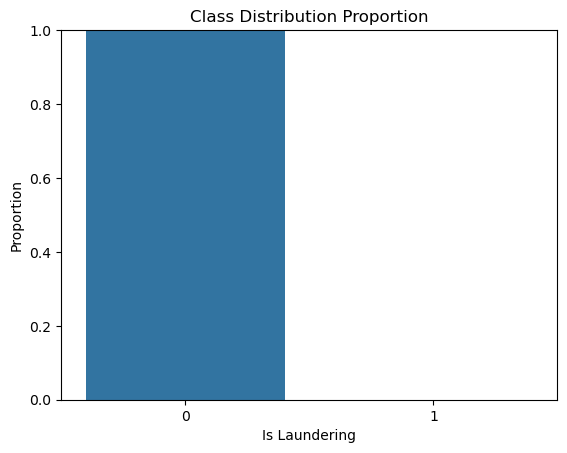

In [162]:
class_counts = df["Is Laundering"].value_counts(normalize=True)


sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Class Distribution Proportion")
plt.ylabel("Proportion")
plt.xlabel("Is Laundering")
plt.ylim(0, 1)
plt.show()

<u>Feature Correlation Heatmap</u>

Visualize relationships between features and the target of Is Laundering

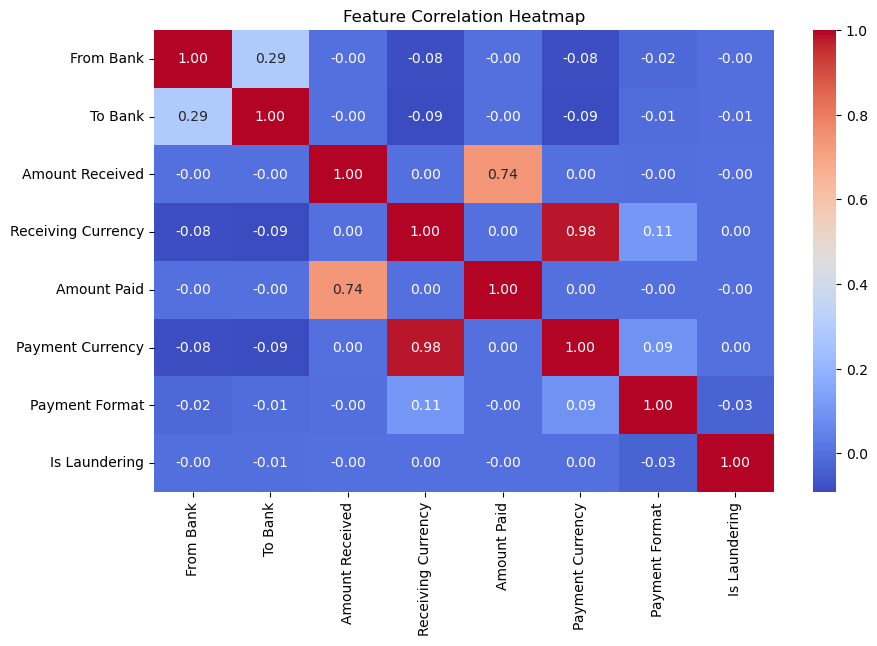

In [163]:
numeric_df = df_encoded.select_dtypes(include=["number"])
corr_matrix = numeric_df.corr()
plt.figure(figsize=(10, 6))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

<u>Normalizing Numeric Features</u>

In [164]:
# normalize feature values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split dataset into training and testing set 80/20 respectively
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

<u>Training the Logistic Regression Model over 1000 iterations</u>

In [165]:
# training logistic regression model
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

<u>Using Evaluation Metrics and a Confusion Matrix to evaluate base model</u>

Accuracy: 0.7867165892793957

Classifcation Report:
               precision    recall  f1-score   support

  Legitimate       1.00      0.79      0.88   1384099
  Laundering       0.00      0.78      0.00       711

    accuracy                           0.79   1384810
   macro avg       0.50      0.79      0.44   1384810
weighted avg       1.00      0.79      0.88   1384810

[[1088896  295203]
 [    154     557]]


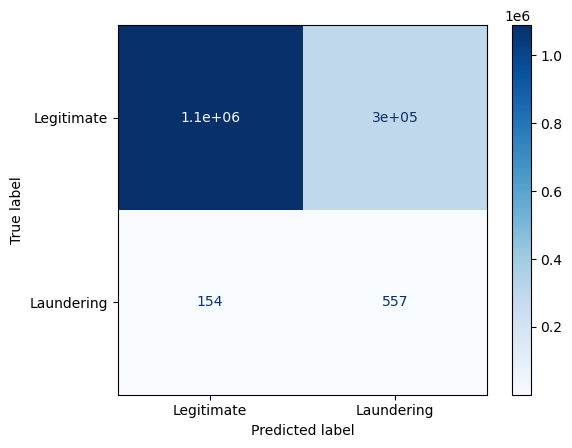

In [166]:
y_pred = lr_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassifcation Report:\n", classification_report(y_test, y_pred, target_names=["Legitimate", "Laundering"]))
ConfusionMatrixDisplay.from_estimator(lr_model, X_test, y_test, display_labels=['Legitimate', "Laundering"], cmap="Blues")
print(confusion_matrix(y_test, y_pred))

## Model Improvement using SMOTE

<u>Using SMOTE to synthetically increase dataset size increasing instances of laundering</u>

<u>Using normalized variables from previous preprocessing and applying SMOTE</u>

In [167]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

#y.value_counts()
y_resampled.value_counts()

Is Laundering
0    6920484
1    6920484
Name: count, dtype: int64

<u>Train/Test split on Resampled Data and fit new Logistic Regression Model</u>

In [168]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

lr_smote = LogisticRegression(max_iter=10000, class_weight="balanced")
lr_smote.fit(X_train_sm, y_train_sm)

LogisticRegression(class_weight='balanced', max_iter=10000)

<u>New SMOTE Model Evaluation</u>

Accuracy (SMOTE) 0.7907144513715441

Classification Report (SMOTE):
               precision    recall  f1-score   support

  Legitimate       0.79      0.79      0.79   1382957
  Laundering       0.79      0.79      0.79   1385237

    accuracy                           0.79   2768194
   macro avg       0.79      0.79      0.79   2768194
weighted avg       0.79      0.79      0.79   2768194

[[1098350  284607]
 [ 294736 1090501]]


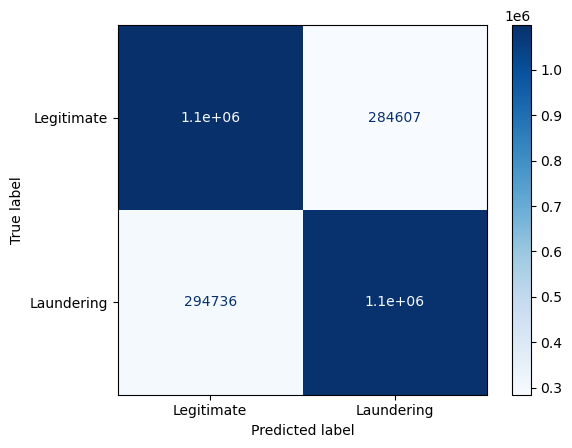

In [169]:
y_pred_sm = lr_smote.predict(X_test_sm)

print("Accuracy (SMOTE)", accuracy_score(y_test_sm, y_pred_sm))
print("\nClassification Report (SMOTE):\n", classification_report(y_test_sm, y_pred_sm, target_names=["Legitimate", "Laundering"]))

ConfusionMatrixDisplay.from_estimator(lr_smote, X_test_sm, y_test_sm, display_labels=["Legitimate", "Laundering"], cmap="Blues")
print(confusion_matrix(y_test_sm, y_pred_sm))

<u>Better Precision and F1-score since there is not still such a huge class imbalance due to synthetic increasing</u>

## Using Random Forest Classifier
<u>Non-SMOTE</u>

<u>Training Random Forest</u>

In [170]:
# training random forest model, can take 2~ minutes
rf_model = RandomForestClassifier(class_weight='balanced_subsample', n_estimators=100, random_state=42, max_depth=15, n_jobs=-1, min_samples_leaf=1)
rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                       n_jobs=-1, random_state=42)

<u>Predicting and Evaluating</u>

Predicting the probabilities for each class. Also setting a custom threshold for the laundering class.

0.867620106729443

Classification Report:
               precision    recall  f1-score   support

  Legitimate       1.00      0.87      0.93   1384099
  Laundering       0.00      0.87      0.01       711

    accuracy                           0.87   1384810
   macro avg       0.50      0.87      0.47   1384810
weighted avg       1.00      0.87      0.93   1384810



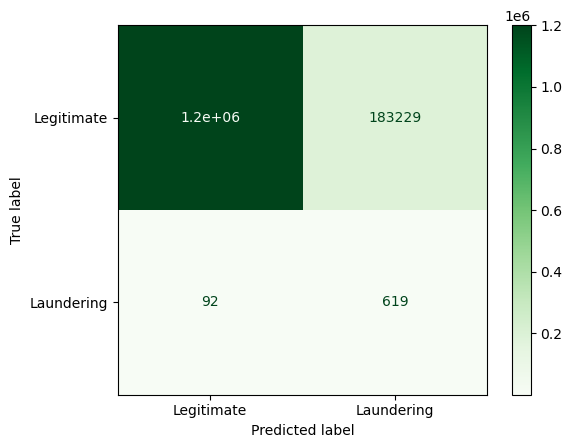

In [171]:
#y_pred_rf = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)

custom_threshold = 0.3
y_pred_thresh = (y_proba[:, 1] >= custom_threshold).astype(int)

print(accuracy_score(y_test, y_pred_thresh))
print("\nClassification Report:\n".format(custom_threshold), classification_report(y_test, y_pred_thresh, target_names=["Legitimate", "Laundering"]))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_thresh, display_labels=["Legitimate", "Laundering"], cmap="Greens")

<u>Random Forest Feature Importance Plot</u>

The features at the top contribute the most to the model's decision making.

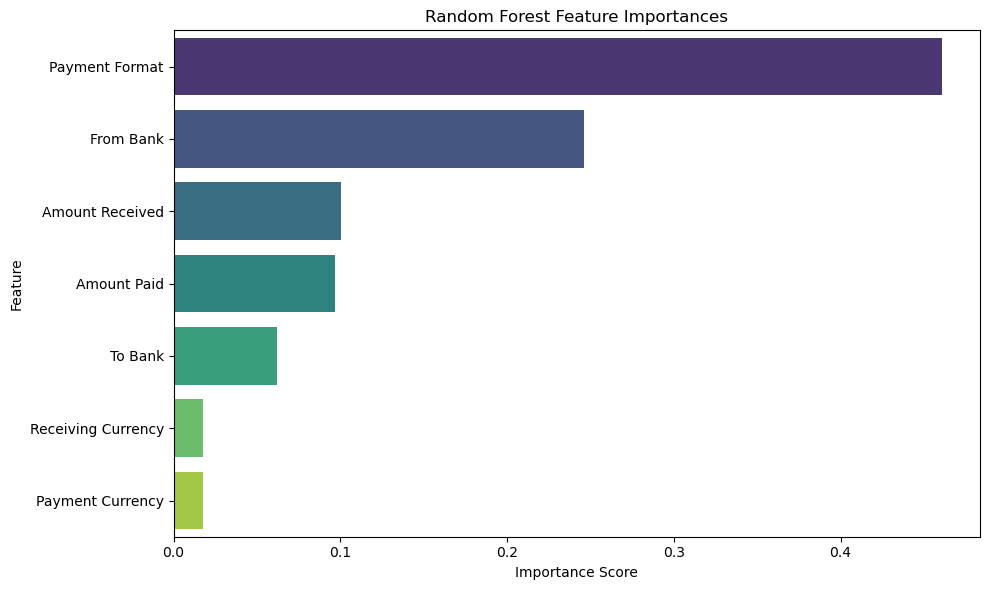

In [172]:
importances = rf_model.feature_importances_
feature_names = X.columns

indices = np.argsort(importances)[::-1]
sorted_features = feature_names[indices]
sorted_importances = importances[indices]

plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importances, y=sorted_features, hue=sorted_features, palette="viridis", legend=False)
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

<u>Threshold Tuning Curve</u>
Visualization of precision-recall tradeoffs from custom threshold

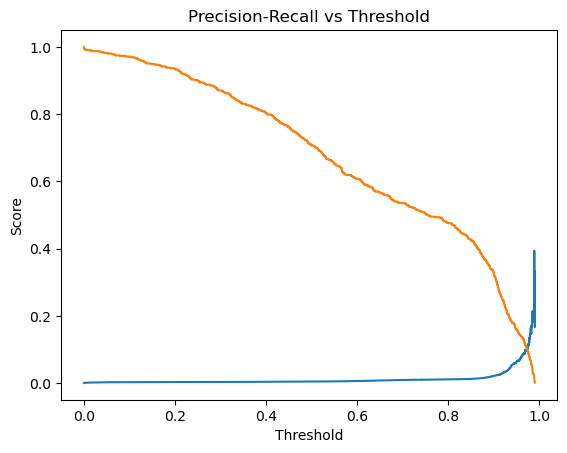

In [173]:
probs = rf_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)

plt.plot(thresholds, precision[:-1], label = 'Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.show()

## Using XGBoost Classifier

Continuing with 80/20 train test split

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

<u>Attempting to handle class imbalance</u>
Given the large class imbalance we are trying to have the model give more importance to the minority/laundering class

In [175]:
imbalance_ratio = (y_train == 0).sum() / (y_train == 1).sum()

<u>Train and fit model</u>

In [176]:
# training XGBoost model
xgb_model = XGBClassifier(scale_pos_weight =imbalance_ratio, eval_metric='logloss', random_state=42)

_ = xgb_model.fit(X_train, y_train) # Supressing .fit output, possible scikit and xgboost incompatability causing error

Generating predicted probabilities and then applying same custom threshold for comparison

In [177]:
# applying custom threshold to predictions
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_pred_xgb = (y_proba_xgb >= 0.3).astype(int)

<u>Model Evaluation</u>

Classification Report (XGBoost, threshold of 0.3):
              precision    recall  f1-score   support

  Legitimate       1.00      0.86      0.92   1384097
  Laundering       0.00      0.90      0.01       713

    accuracy                           0.86   1384810
   macro avg       0.50      0.88      0.46   1384810
weighted avg       1.00      0.86      0.92   1384810



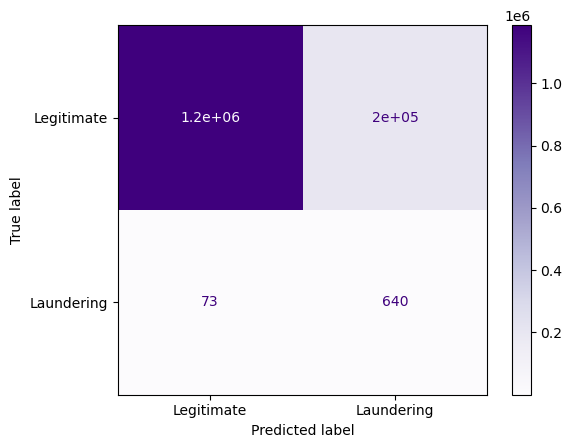

In [178]:
# showing classification metrics / confusion matrix
print("Classification Report (XGBoost, threshold of 0.3):")
print(classification_report(y_test, y_pred_xgb, target_names=["Legitimate", "Laundering"]))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, display_labels=["Legitimate", "Laundering"], cmap="Purples")

<u>Precision Recall Curve for XGBoost</u>

<function matplotlib.pyplot.show(close=None, block=None)>

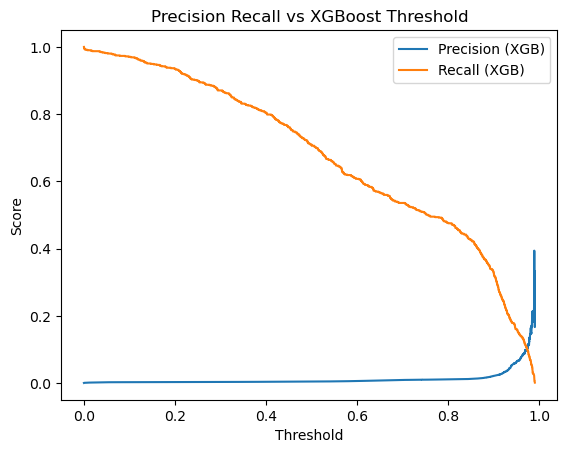

In [179]:
precision, recall, thresholds, precision_recall_curve(y_test, y_proba_xgb)

plt.plot(thresholds, precision[:-1], label='Precision (XGB)')
plt.plot(thresholds, recall[:-1], label='Recall (XGB)')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision Recall vs XGBoost Threshold")
plt.legend()
plt.show